## Importing libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
import matplotlib.pyplot as plt
from PIL import Image  # Import PIL to resize images
import shutil

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter

from cnn import SimpleCNN, train_model

In [2]:
seed = 42
np.random.seed(seed)

Clear the contents of the working directory to save our data after splitting. 

In [3]:
# Set the path to the Kaggle working directory
working_dir = r'..\data\working'

# Delete all files and subdirectories in the working directory
for item in os.listdir(working_dir):
    item_path = os.path.join(working_dir, item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)

# Confirm that the directory is empty
print("Working directory has been cleared.")


Working directory has been cleared.


## Defining Tranformation and Augmentation function

Transformation and augmentation are techniques commonly used in machine learning and computer vision, especially in the context of training deep learning models, including neural networks. These techniques are primarily applied to manipulate and enhance the training data to improve the model's performance, generalization, and robustness.

Image Transformation: In computer vision, image transformation refers to operations that alter the appearance of an image without changing its semantic content. Common image transformations include resizing, cropping, rotation, flipping, and color adjustments.

Data Augmentation: Data augmentation is a technique used to artificially increase the diversity of the training dataset by applying various transformations to the existing data. In computer vision, this often involves generating new training samples by randomly applying operations like rotation, translation, scaling, shearing, flipping, and introducing random noise to the images. Augmentation helps the model generalize better to unseen data and reduces overfitting.

The primary goal of both transformation and augmentation is to make the model more resilient to variations and noise in the input data, ultimately improving its ability to make accurate predictions on real-world, unseen data. These techniques are particularly important in deep learning, where models have a large number of parameters and can easily overfit to the training data if not exposed to diverse examples.

We will also be applying extra augmentation to our minority classes in the train dataset to balance out training dataset so our model can generalize better.

In [4]:

# Define the minority classes in your dataset
class_names = ['malignant', 'normal','benign']
minority_classes = ['malignant', 'normal']

# Define custom data transformations for minority classes
minority_class_transforms = transforms.Compose([
    RandomHorizontalFlip(p=0.9),  # Apply with 90% probability
    RandomRotation(15, expand=False, center=None),
    ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

# Define data transformations for train, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        # Apply custom augmentations to minority classes
        transforms.RandomApply([minority_class_transforms], p=0.5) if any(cls in minority_classes for cls in class_names) else transforms.RandomApply([], p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Approach 1 - Data Split and create folders- excludes mask files

In [5]:
# Set the path to your input folder
data_dir = r'..\data\original'

# Define the paths for the train, validation, and test directories
train_dir = r'..\data\working\train'
val_dir = r'..\data\working\validation'
test_dir = r'..\data\working\test'

# Create a list to store file paths and labels
file_paths = []
labels = []

# Loop through the subdirectories (benign, malignant, normal)
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            if image_file.endswith('.png') and not (image_file.endswith('_mask.png') or 
                                                     image_file.endswith('_mask_1.png') or
                                                     image_file.endswith('_mask_2.png')):
                image_path = os.path.join(label_dir, image_file)
                labels.append(label)
                file_paths.append(image_path)

# Create a DataFrame to store the file paths and labels
data = pd.DataFrame({'Image_Path': file_paths, 'Label': labels})

# Split the dataset into train, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=seed, stratify=data['Label'])
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=seed, stratify=train_data['Label'])



# Create the train, validation, and test directories and subdirectories
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)

# List of tuples containing data and corresponding directories
data_dirs = [(train_data, train_dir), (test_data, test_dir), (val_data, val_dir)]

# Copy the images to the respective directories
for data, directory in data_dirs:
    for _, row in data.iterrows():
        image_path = row['Image_Path']
        label = row['Label']
        shutil.copy(image_path, os.path.join(directory, label))




Get the label counts after split - excludes mask files

In [6]:
dirs = [train_dir, test_dir, val_dir]
subdirs = ['benign', 'malignant', 'normal']

dir_names = ['train', 'test', 'validation']

for i, dir in enumerate(dirs):
    file_counts = {}
    for subdirectory in subdirs:
        subdirectory_path = os.path.join(dir, subdirectory)
        if os.path.exists(subdirectory_path):
            file_count = len(os.listdir(subdirectory_path))
            file_counts[subdirectory] = file_count

    for category, count in file_counts.items():
        print(f"{dir_names[i]} {category}: {count}")



train benign: 280
train malignant: 134
train normal: 85
test benign: 87
test malignant: 42
test normal: 27
validation benign: 70
validation malignant: 34
validation normal: 21


Apply transfromation and augmentation to the datasets. Augmentation is only applied to the training data with extra focus on minority classes to balance the dataset. Calling the function that was defined earlier in the notebook.

In [7]:
data_dir=r'..\data\working'

# Create datasets for train, validation, and test
image_datasets = {
    x: ImageFolder(
        root=os.path.join(data_dir, x),
        transform=data_transforms[x]
    )
    for x in ['train', 'validation', 'test']
}

# Specify batch size for dataloaders
batch_size = 8  # You can adjust this based on your hardware and preferences

# Create dataloaders for train, validation, and test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=8)
               for x in ['train', 'validation', 'test']}

# Calculate dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}

# Get class labels
class_names = image_datasets['train'].classes

# Print dataset sizes and class labels
print("Dataset Sizes:", dataset_sizes)
print("Class Labels:", class_names)

Dataset Sizes: {'train': 499, 'validation': 125, 'test': 156}
Class Labels: ['benign', 'malignant', 'normal']


# Training the models

Point to GPU if exists

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
 # Initialize models
simple_cnn = SimpleCNN().to(device)
optimizer_cnn = optim.Adam(simple_cnn.parameters(), lr=0.001)
scheduler_cnn = lr_scheduler.StepLR(optimizer_cnn, step_size=7, gamma=0.1)
loss_function = nn.CrossEntropyLoss()

# ResNet
resnet101 = models.resnet101(weights=True)
for param in resnet101.parameters():
    param.requires_grad = True
in_features = resnet101.fc.in_features
resnet101.fc = nn.Linear(in_features, len(class_names))
resnet101 = resnet101.to(device)
optimizer_resnet = optim.Adam(resnet101.parameters(), lr=0.00005)
scheduler_resnet = lr_scheduler.StepLR(optimizer_resnet, step_size=7, gamma=0.1)

C:\Users\Erik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## The actual training

In [11]:
# Train both models
print("Training Simple CNN Model \n")
cnn_model, cnn_metrics = train_model(
    simple_cnn, loss_function, optimizer_cnn, scheduler_cnn,
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2
)

print("\nTraining ResNet Model \n")
resnet_model, resnet_metrics = train_model(
    resnet101, loss_function, optimizer_resnet, scheduler_resnet,
    dataloaders, dataset_sizes, class_names, device, num_epochs=20, patience=2
)


Training Simple CNN Model 

Epoch 0/19
----------
train Loss: 0.9122 Acc: 0.6393
validation Loss: 0.9013 Acc: 0.5920

Epoch 1/19
----------
train Loss: 0.8005 Acc: 0.6553
validation Loss: 0.8245 Acc: 0.6800

Epoch 2/19
----------
train Loss: 0.7621 Acc: 0.6814
validation Loss: 0.7605 Acc: 0.6720

Epoch 3/19
----------
train Loss: 0.7240 Acc: 0.6814
validation Loss: 0.7439 Acc: 0.7200

Epoch 4/19
----------
train Loss: 0.5986 Acc: 0.7635
validation Loss: 0.7391 Acc: 0.7040

Epoch 5/19
----------
train Loss: 0.5247 Acc: 0.7996
validation Loss: 0.7540 Acc: 0.7040

Epoch 6/19
----------
train Loss: 0.5076 Acc: 0.8076
validation Loss: 0.7477 Acc: 0.6960
Early stopping after 6 epochs
Training complete in 1m 36s
Best val Loss: 0.7391
              precision    recall  f1-score   support

      benign       0.67      0.93      0.78        70
   malignant       0.80      0.47      0.59        34
      normal       0.88      0.33      0.48        21

    accuracy                           0.70  

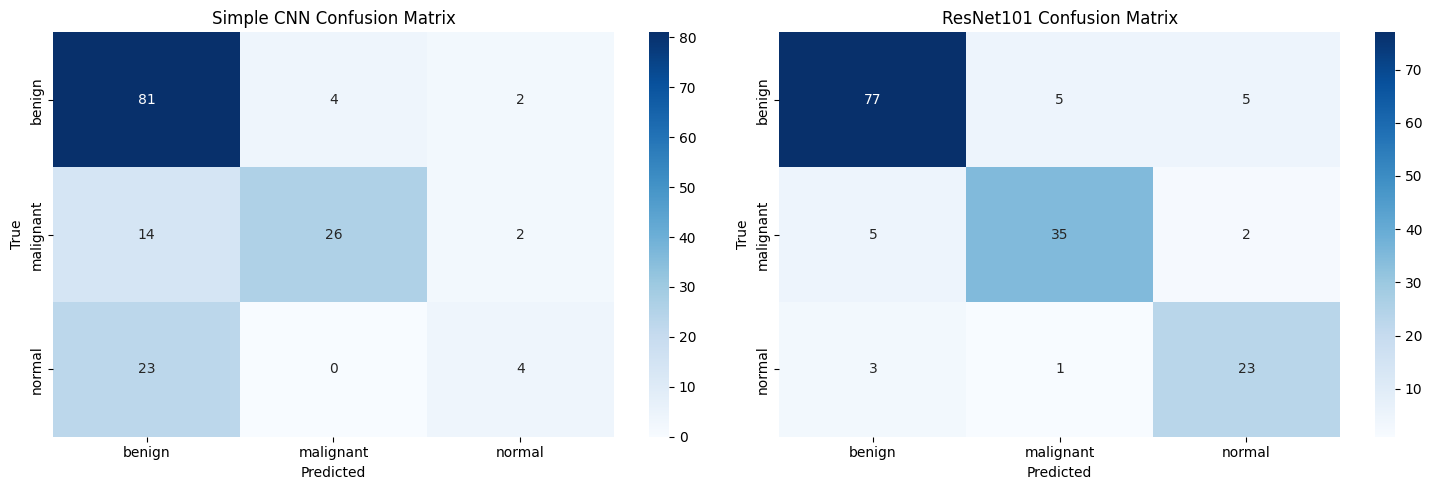


Simple CNN Classification Report:
              precision    recall  f1-score   support

      benign       0.69      0.93      0.79        87
   malignant       0.87      0.62      0.72        42
      normal       0.50      0.15      0.23        27

    accuracy                           0.71       156
   macro avg       0.68      0.57      0.58       156
weighted avg       0.70      0.71      0.67       156


ResNet101 Classification Report:
              precision    recall  f1-score   support

      benign       0.91      0.89      0.90        87
   malignant       0.85      0.83      0.84        42
      normal       0.77      0.85      0.81        27

    accuracy                           0.87       156
   macro avg       0.84      0.86      0.85       156
weighted avg       0.87      0.87      0.87       156



In [12]:
# Get predictions for test set
def get_predictions(model, test_loader):
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return y_true, y_pred

test_loader = DataLoader(image_datasets['test'], batch_size=32, shuffle=False)
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, test_loader)
y_true_resnet, y_pred_resnet = get_predictions(resnet_model, test_loader)

# Plot confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# CNN confusion matrix
conf_matrix_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=class_names, yticklabels=class_names)
ax1.set_title('Simple CNN Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('True')

# ResNet confusion matrix
conf_matrix_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=class_names, yticklabels=class_names)
ax2.set_title('ResNet101 Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('True')

plt.tight_layout()
plt.show()

# Print classification reports
print("\nSimple CNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn, target_names=class_names))

print("\nResNet101 Classification Report:")
print(classification_report(y_true_resnet, y_pred_resnet, target_names=class_names))
        

C:\Users\Erik\AppData\Local\Temp\ipykernel_51388\3885088788.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


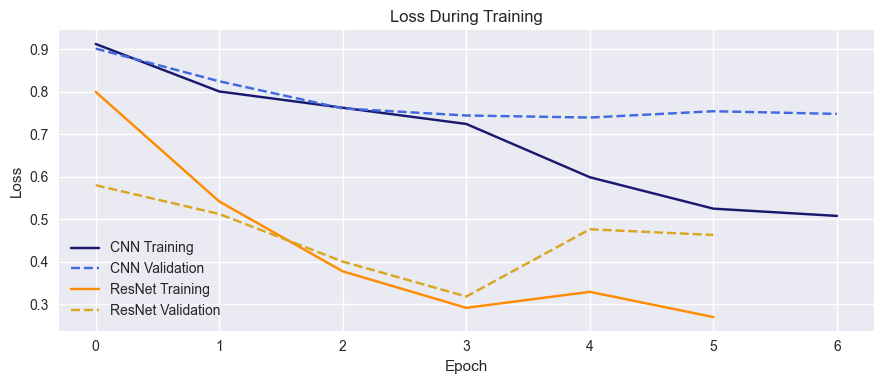

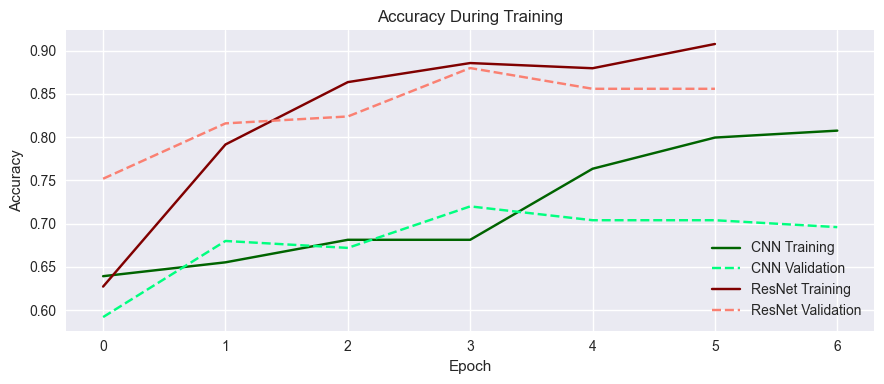

In [37]:
# Set seaborn style theme
sns.set_theme(style="darkgrid")
plt.style.use('seaborn')

# Plot training metrics
# plt.figure(figsize=(14, 5))

# # Loss plot
# plt.subplot(1, 2, 1)
# plt.plot(cnn_metrics['train_loss'], label='CNN Training', color='midnightblue')
# plt.plot(cnn_metrics['val_loss'], label='CNN Validation', color='royalblue', linestyle='--') 
# plt.plot(resnet_metrics['train_loss'], label='ResNet Training', color='darkorange')
# plt.plot(resnet_metrics['val_loss'], label='ResNet Validation', color='goldenrod', linestyle='--')
# plt.title('Loss During Training')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # Accuracy plot  
# plt.subplot(1, 2, 2)
# plt.plot(cnn_metrics['train_acc'], label='CNN Training', color='darkgreen')
# plt.plot(cnn_metrics['val_acc'], label='CNN Validation', color='springgreen', linestyle='--')
# plt.plot(resnet_metrics['train_acc'], label='ResNet Training', color='maroon') 
# plt.plot(resnet_metrics['val_acc'], label='ResNet Validation', color='salmon', linestyle='--')
# plt.title('Accuracy During Training')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig(r'..\figs\cnn_scoring.pdf')


# Plot training metrics
plt.figure(figsize=(9, 4))

# Loss plot
plt.plot(cnn_metrics['train_loss'], label='CNN Training', color='midnightblue')
plt.plot(cnn_metrics['val_loss'], label='CNN Validation', color='royalblue', linestyle='--') 
plt.plot(resnet_metrics['train_loss'], label='ResNet Training', color='darkorange')
plt.plot(resnet_metrics['val_loss'], label='ResNet Validation', color='goldenrod', linestyle='--')
plt.title('Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(r'..\figs\cnn_loss.pdf')


plt.figure(figsize=(9, 4))

plt.plot(cnn_metrics['train_acc'], label='CNN Training', color='darkgreen')
plt.plot(cnn_metrics['val_acc'], label='CNN Validation', color='springgreen', linestyle='--')
plt.plot(resnet_metrics['train_acc'], label='ResNet Training', color='maroon') 
plt.plot(resnet_metrics['val_acc'], label='ResNet Validation', color='salmon', linestyle='--')
plt.title('Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(r'..\figs\cnn_accuracy.pdf')

# plt.figure(figsize=(14, 5))
# # CNN loss
# plt.subplot(1, 2, 1)
# plt.plot(cnn_metrics['train_loss'], label='Training')
# plt.plot(cnn_metrics['val_loss'], label='Validation')
# plt.title('Simple CNN Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# # ResNet loss
# plt.subplot(1, 2, 2)
# plt.plot(resnet_metrics['train_loss'], label='Training')
# plt.plot(resnet_metrics['val_loss'], label='Validation')
# plt.title('ResNet Loss')
# plt.xlabel('Epoch')  
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.savefig(r'..\figs\cnn_loss.pdf')
